In [413]:
## Import base libraries ##
import numpy as np
import math
from scipy import stats
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
import pandas as pd
import GPy

In [501]:
## List of functions for GPR ##
## ============================ ##
def GPy_optimize_like(m, optimizer = "lbfgs", noise = 0):
    '''
    Optimizer methods: 'scg','lbfgs','org-bfgs','fmin_tnc','adam'
    '''
    m.Gaussian_noise.variance = noise
    if noise == 0:
        m.Gaussian_noise.variance.fix()
    m.optimize(optimizer = optimizer)
    
    return m[:-1]


#global error:
def global_error(m, X, y, n = 200):
     #n = number of test points X*
    
    #Xtest with true f(Xtest) values:
    Xtest = np.linspace(min(X), max(X), n).reshape(-1,1)
    ytest = f(Xtest)

    mu, std = m.predict_noiseless(Xnew = Xtest, full_cov = False)

    rmse = np.sqrt(np.mean(np.array([mui - ytesti for mui, ytesti in zip(mu, ytest)])**2)) #predictions - targets
    return rmse


#local error (max error)
def local_error(m, X, y, n=200):
    #n = number of test points X*
    
    #Xtest with true f(Xtest) values:
    Xtest = np.linspace(min(X), max(X), n).reshape(-1,1)
    ytest = f(Xtest)

    mu, std = m.predict_noiseless(Xnew = Xtest, full_cov = False)
    
    localerror = np.max(np.abs(np.array([mui - ytesti for mui, ytesti in zip(mu, ytest)])))
    return localerror


#max std
def max_std(m, X, n = 200):
    #n = number of test points X*
    Xtest = np.linspace(min(X), max(X), n).reshape(-1,1)
    mu, std = m.predict_noiseless(Xnew = Xtest, full_cov = False)
    std = np.sqrt(np.abs(std))[:,0]
    max_std = np.max(std)
    return max_std


def grid_l_var(m, X, y, metric = "loglike", n = 200):
    '''
    metric = "loglike", "rmse", "maxerror", "maxstd"
    '''
    n = 200
    l_list = np.linspace(0.1, 10, n)
    sigma_list = np.linspace(0.1,20,n)
    z_list = []
    i = 0
    if metric == "loglike":
        for li in l_list:
            m.kern.lengthscale = li
            z_sigma = []
            for sigmai in sigma_list:
                m.kern.variance = sigmai
                z_sigma.append(m.log_likelihood())
            z_list.append(np.array(z_sigma))
            i = i+1
            print(i/n,end="\r")
        z_list = np.array(z_list)
    elif metric == "rmse":
        for li in l_list:
            m.kern.lengthscale = li
            z_sigma = []
            for sigmai in sigma_list:
                m.kern.variance = sigmai
                z_sigma.append(global_error(m, X, y))
            z_list.append(np.array(z_sigma))
            i = i+1
            print(i/n,end="\r")
        z_list = np.array(z_list)
    elif metric == "maxerror":
        for li in l_list:
            m.kern.lengthscale = li
            z_sigma = []
            for sigmai in sigma_list:
                m.kern.variance = sigmai
                z_sigma.append(local_error(m, X, y))
            z_list.append(np.array(z_sigma))
            i = i+1
            print(i/n,end="\r")
        z_list = np.array(z_list)
    elif metric == "maxstd":
        for li in l_list:
            m.kern.lengthscale = li
            z_sigma = []
            for sigmai in sigma_list:
                m.kern.variance = sigmai
                z_sigma.append(max_std(m, X))
            z_list.append(np.array(z_sigma))
            i = i+1
            print(i/n,end="\r")
        z_list = np.array(z_list)
    else:
        raise Exception("Not valid metric") 
        

    l_min_id = np.unravel_index(np.nanargmax(z_list), z_list.shape)[0]
    sigma_min_id = np.unravel_index(np.nanargmax(z_list), z_list.shape)[1]
    l_min, sigma_min = l_list[l_min_id], sigma_list[sigma_min_id]
    print("lmax, sigmamax = ", l_min, sigma_min)
    return l_list, sigma_list, z_list


## List of functions for 1D GPR ##
## ============================ ##
#generate points that aren't too close to each other
def generate_points(minX, maxX, N, dim = 1):
    min_distance = np.abs(maxX-minX)/(2*N)
    print(min_distance)
    points = []
    while len(points) < N:
        # Generate a random point
        point = np.random.uniform(minX, maxX, size=(1,dim)) # Adjust range as needed
        if len(points) == 0:
            points.append(point)
        else:
            # Check distance with existing points
            valid_point = True
            for existing_point in points:
                distance = np.abs(point - existing_point)
                if distance < min_distance:
                    valid_point = False
                    break
            if valid_point:
                points.append(point)
    return np.concatenate(points)


# This is the true unknown function we are trying to approximate
#f = lambda x: ( np.exp(-(x+7)**2/(2*9)) + np.exp(-(x+6)**2/(2*9)) + np.exp(-(x+5)**2/(2*9)) + np.exp(-(x+4)**2/(2*9)) + np.exp(-(x+3)**2/(2*9)) + np.exp(-(x+2)**2/(2*9)) + np.exp(-(x+1)**2/(2*9)) + np.exp(-(x-0)**2/(2*9)) + np.exp(-(x-1)**2/(2*9)) + np.exp(-(x-2)**2/(2*9)) + np.exp(-(x-3)**2/(2*9)) + np.exp(-(x-4)**2/(2*9)) + np.exp(-(x-5)**2/(2*9)) + np.exp(-(x-6)**2/(2*9)) + np.exp(-(x-7)**2/(2*9)) + np.exp(-(x-8)**2/(2*9)) ).flatten()
#f = lambda x: ( np.exp(-(x+2)**2/(2*9)) + np.exp(-(x+1)**2/(2*9)) + np.exp(-(x-0)**2/(2*9)) + np.exp(-(x-1)**2/(2*9)) + np.exp(-(x-2)**2/(2*9)) ).flatten()
f = lambda x: ( np.sin(x) ).flatten()
f_scaled = lambda x, minX, maxX: f((maxX - minX)*x+minX) #only if X and not y is scaled


#Lengthscale initial guess
def wavelength(X,y):
    '''
    python write a function that iteratively increases the neighborhood size on the x axis
    around the global maximum of y until it finds the smallest y value in a neighborhood
    where the y values are decreasing just before they begin increasing. return the distance
    along the x axis between the global maximum of y and that smallest y value
    '''
    ymax = np.max(y)
    ymax_i = np.argmax(y)
    ymax_x = X[ymax_i]

    loweri = 0
    upperi= len(y)-1

    ysmall_right = ymax
    ysmall_right_i = ymax_i
    i = ymax_i + 1
    while i <= upperi:    
        if y[i-1] >= y[i]: #if left y > right y
            ysmall_right = y[i]
            ysmall_right_i = i
            i = i+1
        else:
            break

    ysmall_left = ymax
    ysmall_left_i = ymax_i
    i = ymax_i - 1    
    while i >= loweri:
        if y[i] <= y[i+1]: #if left y < right y
            ysmall_left = y[i]
            ysmall_left_i = i
            i = i-1
        else:
            break
            
    if ysmall_right<ysmall_left:
        ysmall = ysmall_right
        ysmall_i = ysmall_right_i
    else:
        ysmall = ysmall_left
        ysmall_i = ysmall_left_i
    #print(ysmall)
    ysmall_x = X[ysmall_i]
    #print(ysmall_x)
    wavelength = np.abs(ymax_x - ysmall_x)
    #print(wavelength)
    return wavelength[0]


def rbf_init_par(X,y):
    init_sigma_n = 0#0.0001 #np.std(y) # guess for observation noise
    init_len_scale = wavelength(X,y)
    init_sigma_f = np.abs(np.max(y) - np.min(y)) #this is the range of the observations
    init_par = [init_sigma_n, init_len_scale, init_sigma_f]
    return init_par
    

#plot the posterior distribution of GPR (GPy version)
def GPy_plot_post(m, X, y):
    '''
    Plot the posterior distribution of GPR
    '''
    N = len(X)
    n = 200 # number of test points X*
    Xtest = np.linspace(min(X), max(X), n).reshape(-1,1)
    
    #full_cov = False -> std (diag of Cov). Otherwise Cov
    mu, std = m.predict_noiseless(Xnew = Xtest, full_cov = False)
    mu = mu[:,0]
    std = np.sqrt(np.abs(std))[:,0]
    
    ## PLOT
    plt.clf()
    plt.figure(figsize=(8,4))

    # Plot training data
    plt.plot(X, y, 'k+', ms=18)
    # Plot test points
    plt.plot(Xtest, f(Xtest), 'b-')
    # Plot predictive mean
    plt.plot(Xtest, mu, 'r--', lw=2)
    # Plot 2std above and below predictive mean
    plt.gca().fill_between(Xtest[:,0], mu-2*std, mu+2*std, color="#dddddd")

    plt.title('Mean predictions +/- 2 std.')
    plt.xlabel(r'$X$')
    plt.ylabel(r'$Y$')
    plt.show()
    
    
## List of functions for 2D GPR ##
## ============================ ##

## 1D Problem

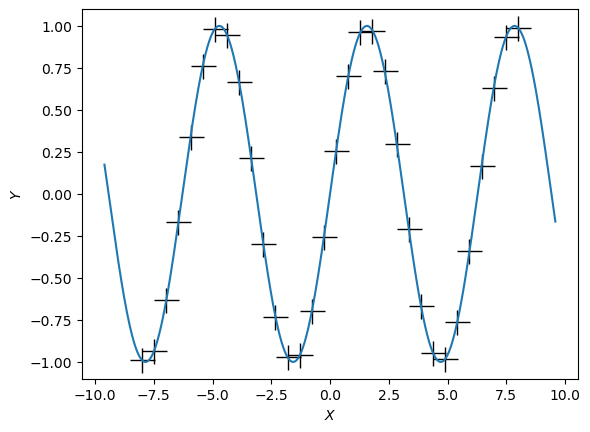

In [502]:
#This is our dataset:
#--------------
#Number of points:
Nog = 32

#X datapoints
Xog = np.linspace(-8,8,Nog).reshape(-1,1) #np.sort(generate_points(-7, 8, Nog, dim = 1),axis = 0)
X = Xog
#Custom X (comment out)
#X = np.array([[-7],[-6],[-5],[-4],[-3],[-2],[-1],[0],[1],[2],[3],[4],[5],[6],[7],[8]]) #custom array
#X = np.array([[-2],[-1],[0],[1],[2]])
#Xog = X #temp if custom array active

minX = np.min(Xog)
maxX = np.max(Xog)

#y datapoints
y = (f(Xog) + np.random.normal(0,0,Nog)).reshape(-1,1) #observations (following true unknown function we wish to approx)

#Function we'd like to estimate --> our goal
xog = np.arange(min(Xog)-abs(min(Xog))*0.2, max(Xog)+abs(max(Xog))*0.2, 0.01).reshape(-1,1)
x = xog.reshape(-1,1)

#Plot
plt.plot(X, y, 'k+', ms=18) #data points
plt.plot(x,f(x))

plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

Initial parameter guess

In [503]:
#Initial guesses of rbf kernel hyperparameters#
init_par = rbf_init_par(X,y)
print(init_par) #sigma_n, l, sigma_f

[0, 3.096774193548388, 1.9787164932467636]


Define a GP model with its kernel:

  index  |  rbf.lengthscale  |  constraints  |  priors
  [0]    |       8.83214038  |      +ve      |        
  index  |  rbf.variance  |  constraints  |  priors
  [0]    |    3.96487611  |      +ve      |        


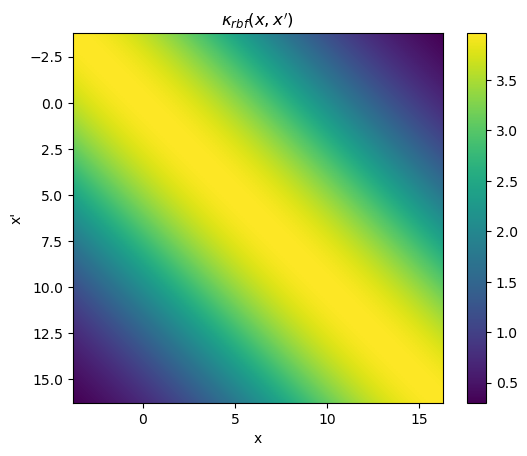

In [19]:
# Define Kernel
#---------------
#RBF kernel with input dimension 1, variance 1, and lengthscale 1
kernel = GPy.kern.RBF(input_dim=1, variance=init_par[2], lengthscale=init_par[1])
#kern.variance.fix(val) if you want to fix the value of this parameter
#---------------

# Plot kernel
K = kernel.K(x,x)

# Plot the covariance of the sample space
plt.pcolor(x.T, x, K)

# Format and annotate plot
plt.gca().invert_yaxis(), plt.gca().axis("image")
plt.xlabel("x"), plt.ylabel("x'"), plt.colorbar()
plt.title("$\kappa_{rbf}(x,x')$");

#return the lengthscale and variance of kernel
print(kernel.lengthscale)
print(kernel.variance)

---
---
## Investigating 2 hyperparameters: $l$ and $\sigma_f$
**Approach 1: Type II maximum likelihood (we have done before, see 2_LikelihoodModelSelection)**
<br>We want to maximize the marginal log-likelihood:
$$
\ln(p(y\vert X,\theta)) = -\frac{n}{2}\ln(2\pi)-\frac{1}{2}\ln\lvert K_y\rvert-\frac{1}{2}y^TK_y^{-1} y.
$$
<br>
We can do this with a finite difference method L-BFGS-B (variation of gradient-descent method):

In [504]:
# Initial guess for sigma and l for the rbf kernel
params0 = [1, 1]
params0

[1, 1]

GPR using initial guesses only (unoptimized)

sigma = 1.000000, l = 1.000000


<Figure size 640x480 with 0 Axes>

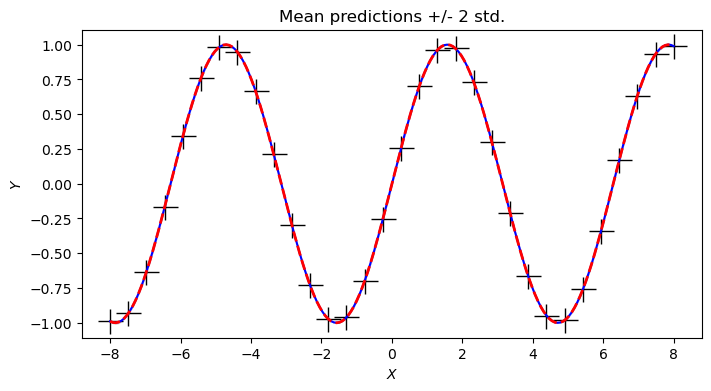

Log-likelihood =  32.48366316470946
RMSE =  9.211100698270021e-05
Max error =  0.0005251919446177533
Max std =  0.003610866320946635


In [505]:
#rbf kernel
kernel = GPy.kern.RBF(input_dim=1, variance=params0[0], lengthscale=params0[1])
m = GPy.models.GPRegression(X,y,kernel)
m.Gaussian_noise.variance = 0
print("sigma = %f, l = %f" % (params0[0], params0[1]) )

GPy_plot_post(m, X, y)
print("Log-likelihood = ", m.log_likelihood())
print("RMSE = ", global_error(m, X, y))
print("Max error = ",local_error(m, X, y))
print("Max std = ", max_std(m, X))

<Figure size 640x480 with 0 Axes>

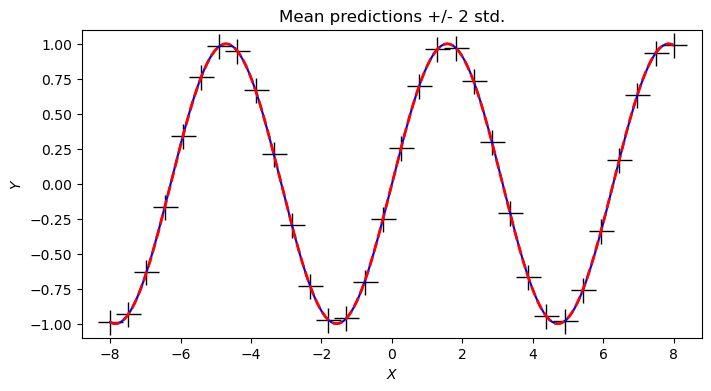

Log-likelihood =  -3714.1188341915645
RMSE =  0.0015772867343565669
Max error =  0.003183702454230424
Max std =  8.468107421836394e-05


In [506]:
#standard periodic kernel
kernel = GPy.kern.StdPeriodic(input_dim=1, variance=1, period=6.28, lengthscale=1)
m = GPy.models.GPRegression(X,y,kernel)
m.Gaussian_noise.variance = 0

GPy_plot_post(m, X, y)
print("Log-likelihood = ", m.log_likelihood())
print("RMSE = ", global_error(m, X, y))
print("Max error = ",local_error(m, X, y))
print("Max std = ", max_std(m, X))

Optimizing GPRs

sigma = 25.280313, l = 3.309861
Var of y =  0.5228912160435286


<Figure size 640x480 with 0 Axes>

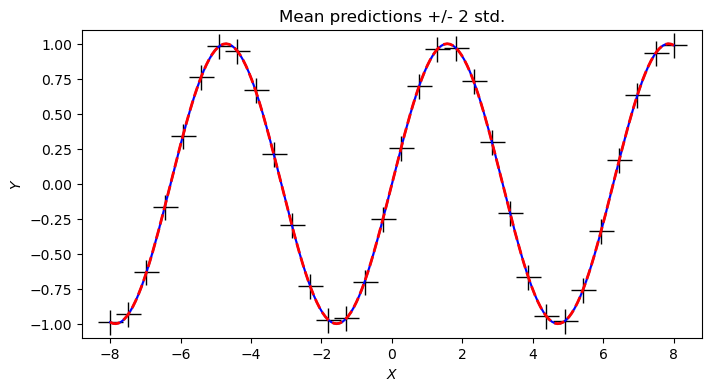

Log-likelihood =  138.14970404266427
RMSE =  1.2362454458396523e-05
Max error =  4.135267028582135e-05
Max std =  0.00011348566274082766


In [507]:
#rbf kernel
kernel = GPy.kern.RBF(input_dim=1, variance=params0[0], lengthscale=params0[1])
m = GPy.models.GPRegression(X,y,kernel)
#m.rbf.variance.fix()
sigma, l = GPy_optimize_like(m, noise = 0)
print("sigma = %f, l = %f" % (sigma, l) )
print("Var of y = ", np.var(y))

GPy_plot_post(m, X, y)
print("Log-likelihood = ", m.log_likelihood())
print("RMSE = ", global_error(m, X, y))
print("Max error = ", local_error(m, X, y))
print("Max std = ", max_std(m, X))

Var, period, lscale =  0.8973850438963267 6.283185315467567 2.153835441731339
Var of y =  0.5228912160435286


<Figure size 640x480 with 0 Axes>

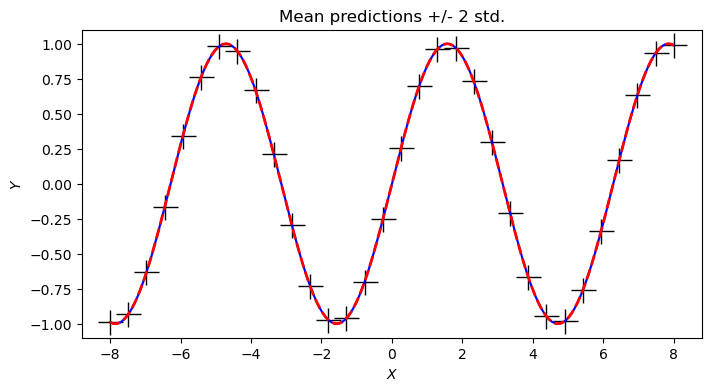

Log-likelihood =  198.2360885696274
RMSE =  1.0383590788046453e-08
Max error =  1.5999293001556225e-08
Max std =  6.180314134680102e-05


In [510]:
kernel = GPy.kern.StdPeriodic(input_dim=1, variance=1, period=6.28, lengthscale=1)
m = GPy.models.GPRegression(X,y,kernel)
#m.kern.variance.fix()
#m.kern.lengthscale.fix()
a, b, c = GPy_optimize_like(m, noise = 0)
print("Var, period, lscale = ", a, b , c)
print("Var of y = ", np.var(y))

GPy_plot_post(m, X, y)
print("Log-likelihood = ", m.log_likelihood())
print("RMSE = ", global_error(m, X, y))
print("Max error = ", local_error(m, X, y))
print("Max std = ", max_std(m, X))

In [483]:
l_list, sigma_list, z_list = grid_l_var(m, X, y, metric = "loglike", n = 200)

lmax, sigmamax =  7.661809045226131 20.0


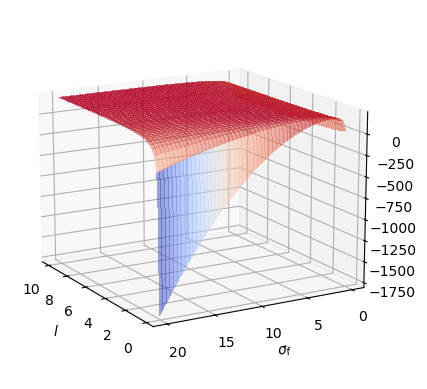

In [484]:
# Meshgrid of L and Sigma
L, Sigma = np.meshgrid(l_list, sigma_list)

# Render plots
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(L, Sigma, z_list, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha = 0.5)
ax.view_init(15, 150)
#ax.scatter(l, sigma, m.log_likelihood(), marker = '+', color = "black")

# plot settings
ax.set_xlabel(r'$l$') 
ax.set_ylabel(r'$\sigma_f$')

plt.show() 

---
**Approach 2: MCMC method**
<br>
We would like to find the posterior over the hyperparameters from Bayes' rule:
$$
p(\theta\vert y,X) = \frac{p(y\vert X,\theta)p(\theta)}{p(y\vert X)}
$$
where $p(\theta)$ is the hyper-prior (prior distribution for hyperparameters) and the marginal likelihood (evidence) is
$$
p(y\vert X) = \int p(y\vert X,\theta)p(\theta) d\theta
$$
So far we've used the MCMC method Metropolis-Hastings (MH) as our sampler which wasn't the most efficient and may require a long time to converge. Hamiltonian Monte Carlo (HMC) uses first-order gradients of the log posterior rather than a random walk. The latest sampling technique is called the No-U-Turn Sampler (NUTS), an upgrade from HMC. Unlike HMC, NUTS does not require us to specify the number of steps or step size parameters, which it automatically determines through each iteration.
<br><br>
We'll continue to use the Metropolis-Hastings algorithm for now. In the next notebook we'll implement GPs with PyMC, which utilizes NUTS in its update of the posterior.

---
Let's implement the Hybrid Monte Carlo through GPy:

In [250]:
m = GPy.models.GPRegression(X,y,kernel)
#m.unconstrain()

#Make a gamma prior and set it as the prior for the lengthscale
gamma_prior = GPy.priors.Gamma.from_EV(5,1.1)

#Make a uniform prior and set it as the prior for the variance
uniform_prior = GPy.priors.Uniform(0,200)

m.rbf.lengthscale.set_prior(uniform_prior)
m.rbf.variance.set_prior(uniform_prior)

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


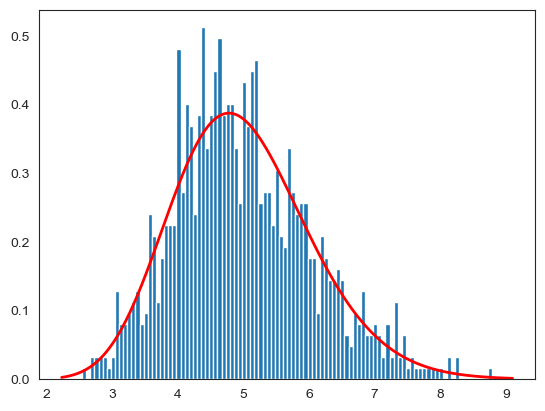

In [150]:
gamma_prior.plot()

In [251]:
m.Gaussian_noise.variance = 0
m.Gaussian_noise.variance.fix()
m.optimize()
m

GP_regression.,value,constraints,priors
rbf.variance,180.13295091825626,+ve,"[0, 2e+02]"
rbf.lengthscale,5.1856359657672115,+ve,"[0, 2e+02]"
Gaussian_noise.variance,0.0,+ve fixed,


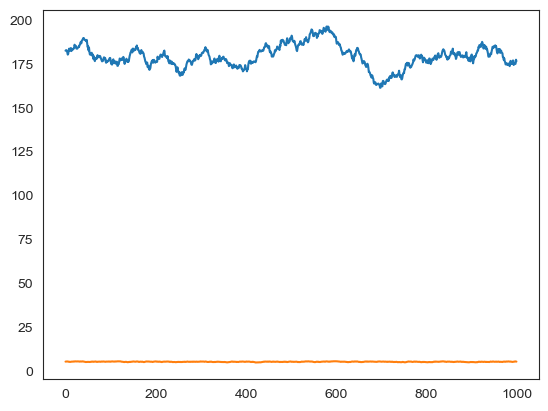

In [252]:
#Draw 1000 samples from the GP model
hmc = GPy.inference.mcmc.HMC(m, stepsize = 5e-2)
s = hmc.sample(num_samples=1000) # Burnin

#plot the samples
plt.plot(s)

Text(0, 0.5, 'lengthscale')

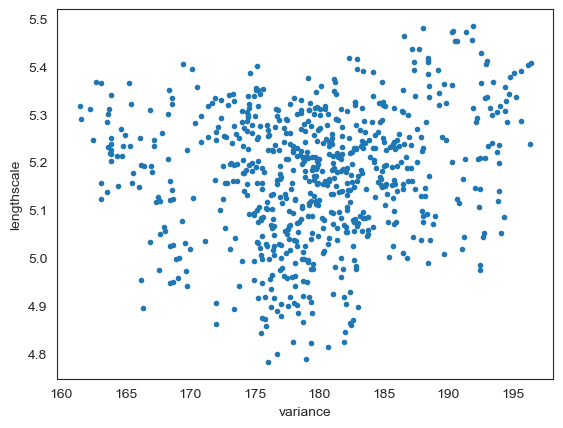

In [253]:
labels = ["variance","lengthscale"]
samples = s[300:] # cut out the burn-in period
plt.plot(samples[:,0], samples[:,1],'.')
plt.xlabel(labels[0]); plt.ylabel(labels[1])

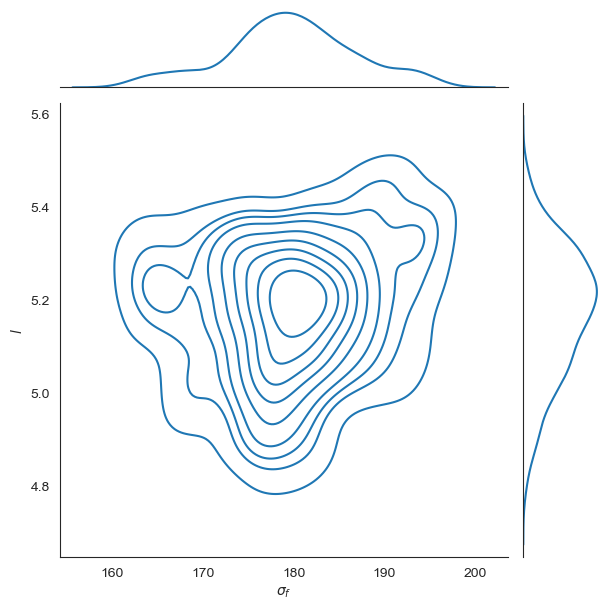

In [254]:
#Distribution of l and sigma
sns.jointplot(x=samples[:,0],y=samples[:,1], kind='kde')
plt.xlabel(r'$\sigma_f$')
plt.ylabel(r'$l$')
plt.show()

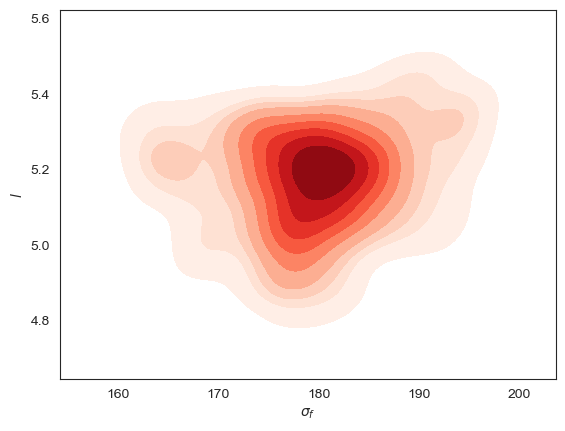

In [255]:
sns.set_style("white")
sns.kdeplot(x=samples[:,0], y=samples[:,1], cmap="Reds", fill=True)
plt.xlabel(r'$\sigma_f$')
plt.ylabel(r'$l$')
plt.show()

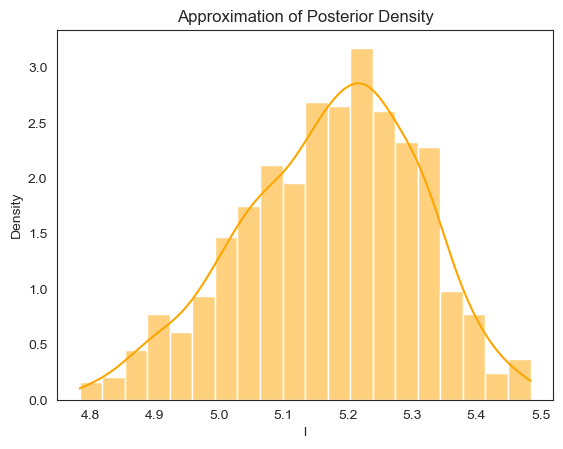

In [256]:
# Plot of MCMC approximation of the posterior
sns.histplot(samples[:,1], kde=True, bins = 20, color="orange", stat="density")
plt.xlabel('l')
plt.title('Approximation of Posterior Density')
plt.show()

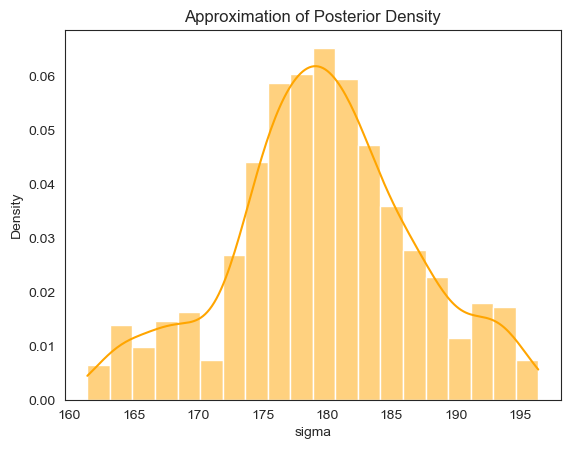

In [257]:
# Plot of MCMC approximation of the posterior
sns.histplot(samples[:,0], kde=True, bins = 20, color="orange", stat="density")
plt.xlabel('sigma')
plt.title('Approximation of Posterior Density')
plt.show()

**Adaptive sampling**
<br>
We now add a new observation at the point of maximum variance. We use the previous posterior distributions for $l$ and $\sigma_f$ as the priors for the new posterior distributions.

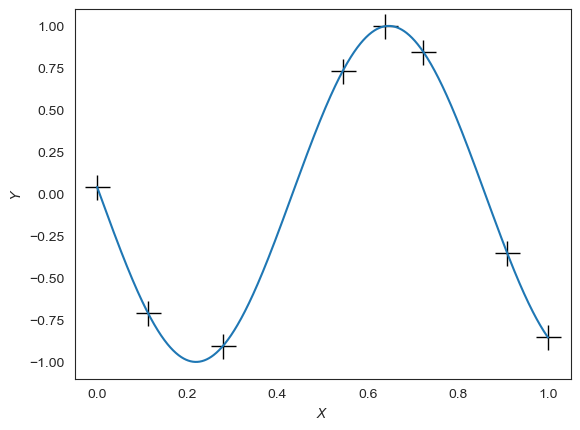

In [24]:
#Original plot
#Plot
plt.plot(X, y, 'k+', ms=18) #data points
plt.plot(x,f_scaled(x,minX,maxX))

plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

In [25]:
#Xtest that returns largest predictive std is
def find_Xtest(m, X, y):
    Xtest_og = np.linspace(min(X), max(X), n).reshape(-1,1)
    mu, std = m.predict_noiseless(Xnew = Xtest_og, full_cov = False)
    mu = mu[:,0]
    std = np.sqrt(np.abs(std))[:,0]
    Xtest_maxstd = Xtest_og[np.argmax(std)][0]
    return Xtest_maxstd

Xtest_maxstd = find_Xtest(m,X,y)
Xtest_maxstd

0.3870458135860979

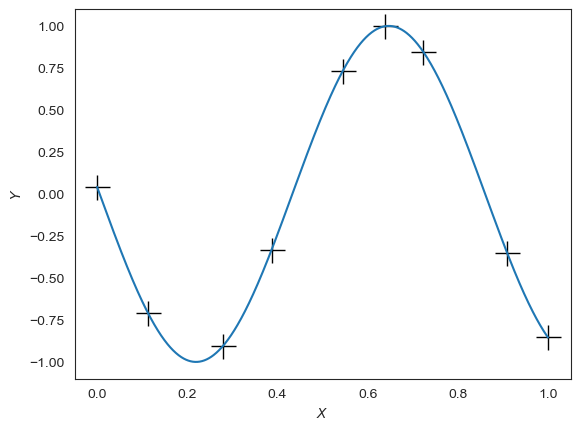

In [26]:
X_new = X
Xnew = np.sort(np.append(X_new,Xtest_maxstd)).reshape(-1,1)
Xognew = (maxX - minX)*Xnew + minX
ynew = (f(Xognew) + np.random.normal(0,0,Nog+1)).reshape(-1,1) #observations (following true unknown function we wish to approx)

#Plot
plt.plot(Xnew, ynew, 'k+', ms=18) #data points
plt.plot(x,f_scaled(x,minX,maxX))

plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

In [27]:
from GPy.core.parameterization.priors import Prior
import weakref
class KDEPrior(Prior):
    _instances = []

    def __new__(cls, samples):  # Singleton:
#         if cls._instances:
#             cls._instances[:] = [instance for instance in cls._instances if instance()]
#             for instance in cls._instances:
#                 if instance().samples == samples:
#                     return instance()
        newfunc = super(Prior, cls).__new__
        if newfunc is object.__new__:
            o = newfunc(cls)
        else:
            o = newfunc(cls, samples)
        cls._instances.append(weakref.ref(o))
        return cls._instances[-1]()

    def __init__(self, samples):
        self.samples = samples
        self.kde = gaussian_kde(self.samples)

    def __str__(self):
        return "KDE"

    def lnpdf(self, x):
        return np.log(self.kde.pdf(x))

    def lnpdf_grad(self, x):
        # Approximate the gradient by calculating the difference in the log PDF at two close points
        epsilon = 1e-8
        log_pdf_grad = (np.log(self.kde.pdf(x + epsilon)) - np.log(self.kde.pdf(x - epsilon))) / (2 * epsilon)
        return log_pdf_grad

    def rvs(self, n=None):
        # Generate random samples from the KDE-based prior
        return self.kde.resample(size=n).flatten()

In [28]:
m = GPy.models.GPRegression(Xnew,ynew,kernel)

#Make a uniform prior and set it as the prior for the variance
kde_prior_sigma = KDEPrior(samples[:,0])
kde_prior_l = KDEPrior(samples[:,1])

m.rbf.lengthscale.set_prior(kde_prior_l)
m.rbf.variance.set_prior(kde_prior_sigma)

m

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


GP_regression.,value,constraints,priors
rbf.variance,1.59711610655411,+ve,KDE
rbf.lengthscale,0.29361628069084456,+ve,KDE
Gaussian_noise.variance,1.0,+ve,


In [29]:
m.Gaussian_noise.variance = 0
m.Gaussian_noise.variance.fix()
m.optimize()
m

 C:\Users\Sasha\anaconda3\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:divide by zero encountered in log


GP_regression.,value,constraints,priors
rbf.variance,1.5937863363759492,+ve,KDE
rbf.lengthscale,0.3107813516089392,+ve,KDE
Gaussian_noise.variance,0.0,+ve fixed,


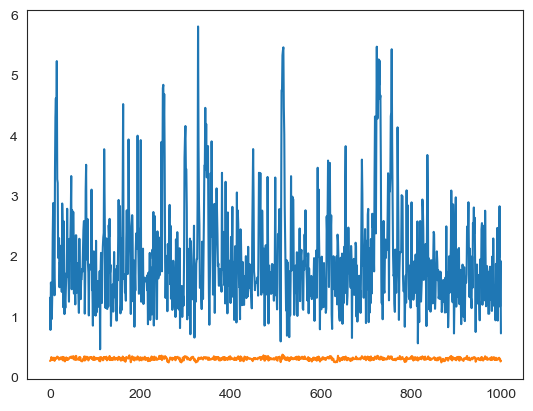

In [30]:
#Draw 1000 samples from the GP model
hmc = GPy.inference.mcmc.HMC(m, stepsize = 5e-2)
s_new = hmc.sample(num_samples=1000) # Burnin

#plot the samples
plt.plot(s_new)

Text(0, 0.5, 'lengthscale')

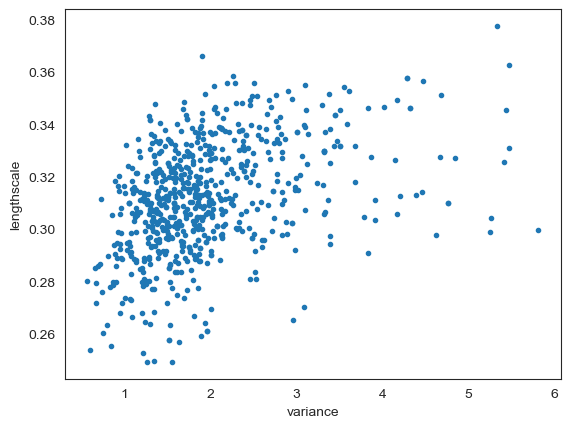

In [31]:
samples_new = s_new[300:] # cut out the burn-in period
plt.plot(samples_new[:,0], samples_new[:,1],'.')
plt.xlabel(labels[0]); plt.ylabel(labels[1])

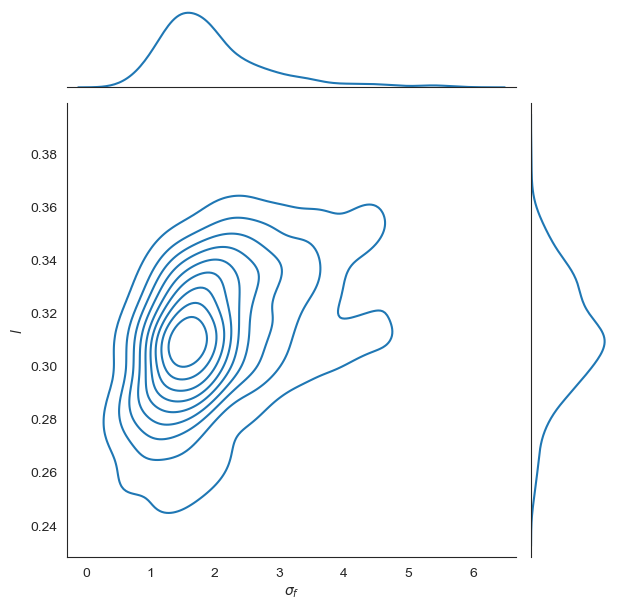

In [32]:
#Distribution of l and sigma
sns.jointplot(x=samples_new[:,0],y=samples_new[:,1], kind='kde')
plt.xlabel(r'$\sigma_f$')
plt.ylabel(r'$l$')
plt.show()

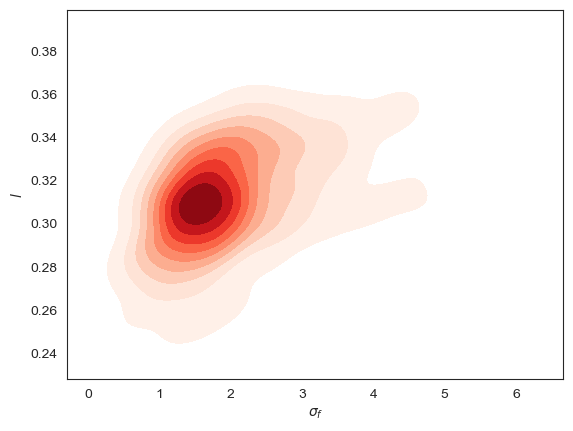

In [33]:
sns.set_style("white")
sns.kdeplot(x=samples_new[:,0], y=samples_new[:,1], cmap="Reds", fill=True)
plt.xlabel(r'$\sigma_f$')
plt.ylabel(r'$l$')
plt.show()

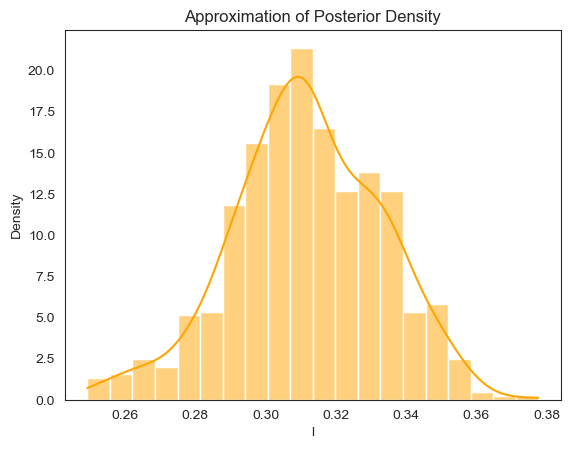

In [34]:
# Plot of MCMC approximation of the posterior
sns.histplot(samples_new[:,1], kde=True, bins = 20, color="orange", stat="density")
plt.xlabel('l')
plt.title('Approximation of Posterior Density')
plt.show()

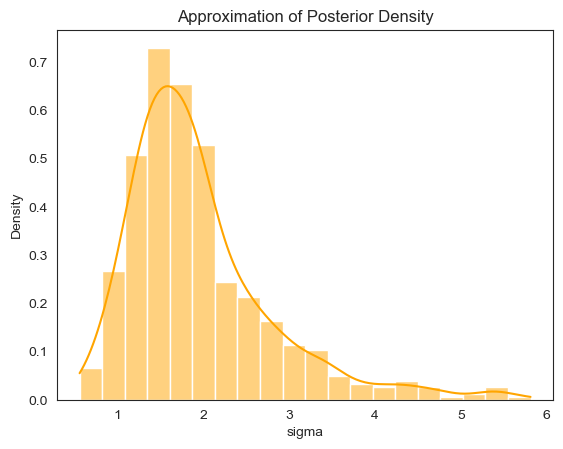

In [35]:
# Plot of MCMC approximation of the posterior
sns.histplot(samples_new[:,0], kde=True, bins = 20, color="orange", stat="density")
plt.xlabel('sigma')
plt.title('Approximation of Posterior Density')
plt.show()

<Figure size 640x480 with 0 Axes>

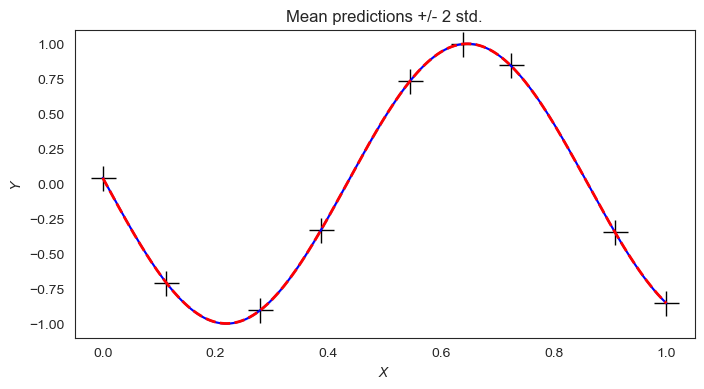

In [36]:
GPy_plot_post(m, Xnew, ynew)

Sources:
* https://nbviewer.org/github/SheffieldML/notebook/tree/master/GPy/